In [190]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

In [191]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [192]:
import operator
from typing import List
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [197]:
def call_model(state:MessagesState):
    question=state["messages"]
    # question=[HumanMessage(question).content]
    response=llm.invoke(question)
    return {"messages":[response]}

### this code is only for the testing

In [198]:
state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.188395288, 'prompt_time': 0.000184326, 'queue_time': 0.055317794, 'total_time': 0.188579614}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--f844cde5-363c-4603-9385-9c21b165e9a3-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

### Design a simple workflow without tool calling/

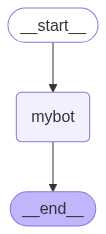

In [199]:
workflow=StateGraph(MessagesState)

workflow.add_node("mybot",call_model)

workflow.add_edge(START, "mybot")
workflow.add_edge("mybot", END)

app=workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [200]:
input={"messages":["hi hellow how are you?"]}
app.invoke(input)

{'messages': [HumanMessage(content='hi hellow how are you?', additional_kwargs={}, response_metadata={}, id='a448286d-5e34-416a-bd23-1501033211eb'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 10, 'total_tokens': 54, 'completion_time': 0.200763966, 'prompt_time': 0.000220586, 'queue_time': 0.054847384, 'total_time': 0.200984552}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--2666aed2-25af-4ca3-993d-5a99d5e484fd-0', usage_metadata={'input_tokens': 10, 'output_tokens': 44, 'total_tokens': 54})]}

### this is a workflow with tool calling
Create a tool

In [201]:
@tool
def search_weather(query:str):
    """this is my custom tool for searching weather"""
    if "delhi" in query.lower():
        return "temp is 45 degree and sunny"
    return "temp is 25 degree and cloudy"

In [202]:
search_weather.invoke("what is a tempurature in kashmir")

'temp is 25 degree and cloudy'

In [203]:
search_weather.invoke("what is a tempurature in delhi")

'temp is 45 degree and sunny'

In [204]:
tools=[search_weather]

In [205]:
llm_with_tool=llm.bind_tools(tools)

In [206]:
response=llm_with_tool.invoke("what is a weather in delhi?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '82w11z2nv', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 133, 'total_tokens': 270, 'completion_time': 0.659397818, 'prompt_time': 0.008586196, 'queue_time': 0.05521496399999999, 'total_time': 0.667984014}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1c46290a-f223-4644-90ea-7ce65f5ca087-0', tool_calls=[{'name': 'search_weather', 'args': {'query': 'weather in Delhi'}, 'id': '82w11z2nv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 137, 'total_tokens': 270})

In [207]:
response.tool_calls

[{'name': 'search_weather',
  'args': {'query': 'weather in Delhi'},
  'id': '82w11z2nv',
  'type': 'tool_call'}]

In [208]:
def call_model(state=MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    print("llm response: ", response)
    return {"messages":[response]}

In [209]:
## Testing code

input={"messages":["what is a weather in delhi?"]}
response=call_model(input)

llm response:  content='' additional_kwargs={'tool_calls': [{'id': 'wgqy345p9', 'function': {'arguments': '{"query":"Delhi"}', 'name': 'search_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 165, 'prompt_tokens': 133, 'total_tokens': 298, 'completion_time': 0.733036997, 'prompt_time': 0.008570087, 'queue_time': 0.055139472999999994, 'total_time': 0.741607084}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--6ce4ac15-b756-4f0e-9c7a-de072e86fa08-0' tool_calls=[{'name': 'search_weather', 'args': {'query': 'Delhi'}, 'id': 'wgqy345p9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 133, 'output_tokens': 165, 'total_tokens': 298}


In [210]:
response["messages"][-1].content

''

In [211]:
response["messages"][-1].tool_calls

[{'name': 'search_weather',
  'args': {'query': 'Delhi'},
  'id': 'wgqy345p9',
  'type': 'tool_call'}]

### here my router function
now whatever will come from call_model router funtion will redirect this to the appropriate tool

In [212]:
def router_fun(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]  ## LLM model automatically give us tool_calls artribute based on question
    if last_message.tool_calls:
        return "tools"
    return END

In [213]:
tool_node=ToolNode(tools)

In [214]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search_weather': StructuredTool(name='search_weather', description='this is my custom tool for searching weather', args_schema=<class 'langchain_core.utils.pydantic.search_weather'>, func=<function search_weather at 0x0000023B247B6B60>)}, tool_to_state_args={'search_weather': {}}, tool_to_store_arg={'search_weather': None}, handle_tool_errors=True, messages_key='messages')

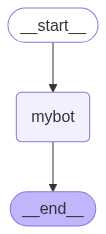

In [215]:
workflow2=StateGraph(MessagesState)

workflow2.add_node("llmwithtool",call_model)
workflow2.add_node("mytools",tool_node)

workflow2.add_edge(START, "llmwithtool")

workflow2.add_conditional_edges("llmwithtool",
                               router_fun,
                               {"tools":"mytools",
                                END:END})

app2=workflow2.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [216]:

app2.invoke({"messages":["what is a weather in bengraluru?"]})

llm response:  content='' additional_kwargs={'tool_calls': [{'id': 'trftbxhsc', 'function': {'arguments': '{"query":"Bengaluru weather"}', 'name': 'search_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 155, 'prompt_tokens': 135, 'total_tokens': 290, 'completion_time': 0.683328028, 'prompt_time': 0.008678244, 'queue_time': 0.053504206, 'total_time': 0.692006272}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--3525d50c-a5c6-4e51-92c1-f487b3df34b0-0' tool_calls=[{'name': 'search_weather', 'args': {'query': 'Bengaluru weather'}, 'id': 'trftbxhsc', 'type': 'tool_call'}] usage_metadata={'input_tokens': 135, 'output_tokens': 155, 'total_tokens': 290}


{'messages': [HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='38b5fe36-8bfb-46d8-9989-53c9c41d5cde'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'trftbxhsc', 'function': {'arguments': '{"query":"Bengaluru weather"}', 'name': 'search_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 155, 'prompt_tokens': 135, 'total_tokens': 290, 'completion_time': 0.683328028, 'prompt_time': 0.008678244, 'queue_time': 0.053504206, 'total_time': 0.692006272}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3525d50c-a5c6-4e51-92c1-f487b3df34b0-0', tool_calls=[{'name': 'search_weather', 'args': {'query': 'Bengaluru weather'}, 'id': 'trftbxhsc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 155, 'total_tokens': 290}),
  ToolMessage(content='temp is 25 degree and c

In [217]:
app2.invoke({"messages":["what is a weather in delhi?"]})

llm response:  content='' additional_kwargs={'tool_calls': [{'id': '23gbztj6e', 'function': {'arguments': '{"query":"Delhi"}', 'name': 'search_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 133, 'total_tokens': 215, 'completion_time': 0.389075584, 'prompt_time': 0.008599157, 'queue_time': 0.05650933700000001, 'total_time': 0.397674741}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--5c713e42-6e7b-434e-a015-324ef89006d2-0' tool_calls=[{'name': 'search_weather', 'args': {'query': 'Delhi'}, 'id': '23gbztj6e', 'type': 'tool_call'}] usage_metadata={'input_tokens': 133, 'output_tokens': 82, 'total_tokens': 215}


{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='d5f5ab17-3253-4eca-893e-7a15a8ab2af1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '23gbztj6e', 'function': {'arguments': '{"query":"Delhi"}', 'name': 'search_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 133, 'total_tokens': 215, 'completion_time': 0.389075584, 'prompt_time': 0.008599157, 'queue_time': 0.05650933700000001, 'total_time': 0.397674741}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c713e42-6e7b-434e-a015-324ef89006d2-0', tool_calls=[{'name': 'search_weather', 'args': {'query': 'Delhi'}, 'id': '23gbztj6e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 82, 'total_tokens': 215}),
  ToolMessage(content='temp is 45 degree and sunny', name='search_wea

In [218]:
app2.invoke({"messages":["hi how are you?"]})

llm response:  content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 130, 'total_tokens': 268, 'completion_time': 0.515066678, 'prompt_time': 0.009090568, 'queue_time': 0.053475613, 'total_time': 0.524157246}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--9b7d6399-c5a6-4abb-b4ac-4123340094f4-0' usage_metadata={'input_tokens': 130, 'output_tokens': 138, 'total_tokens': 268}


{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='fa4f1461-8550-438c-b001-aacffb7aaa2c'),
  AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 130, 'total_tokens': 268, 'completion_time': 0.515066678, 'prompt_time': 0.009090568, 'queue_time': 0.053475613, 'total_time': 0.524157246}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--9b7d6399-c5a6-4abb-b4ac-4123340094f4-0', usage_metadata={'input_tokens': 130, 'output_tokens': 138, 'total_tokens': 268})]}

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


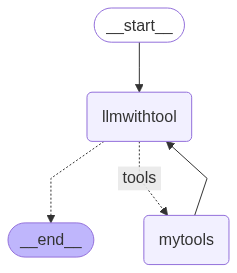

In [219]:
## create loop
workflow2.add_edge("mytools","llmwithtool")

app3=workflow2.compile()
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [220]:
for output in app3.stream({"messages":["what is a wheather in new delhi?"]}):
    for key, value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

llm response:  content='' additional_kwargs={'tool_calls': [{'id': 'mspa7grr4', 'function': {'arguments': '{"query":"what is a wheather in new delhi?"}', 'name': 'search_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 262, 'prompt_tokens': 135, 'total_tokens': 397, 'completion_time': 1.236980273, 'prompt_time': 0.008801252, 'queue_time': 0.054923151999999996, 'total_time': 1.245781525}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--5e9218b9-9838-42e7-9957-886f8f8f6299-0' tool_calls=[{'name': 'search_weather', 'args': {'query': 'what is a wheather in new delhi?'}, 'id': 'mspa7grr4', 'type': 'tool_call'}] usage_metadata={'input_tokens': 135, 'output_tokens': 262, 'total_tokens': 397}
here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mspa7grr4', 'function': {'arguments': '{"query":"wha

### Now suppose there are 2 task in same condition e.g. weather and hotel booking

"what is a weather in delhi can you tell me some good hotel for staying in north delhi"

In [221]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

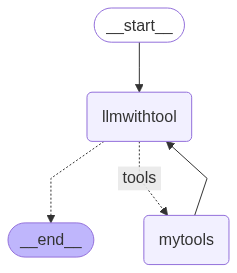

In [240]:
workflow3=StateGraph(MessagesState)

workflow3.add_node("llmwithtool", call_model)
workflow3.add_node("mytools", tool_node)

workflow3.add_edge(START, "llmwithtool")

workflow3.add_conditional_edges("llmwithtool",
                                router_fun,
                                {"tools":"mytools",
                                 END:END})
workflow3.add_edge("mytools","llmwithtool")

app4=workflow3.compile(checkpointer=memory)
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [241]:
config={"configurable": {"thread_id": "1"}}

In [242]:
events=app.stream({"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values")

# config : runtime config 
# "values"`: Emit all values in the state after each step, including interrupts.

In [243]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================

<think>
Okay, so I need to figure out what the weather is like in New Delhi. I remember that New Delhi is the capital of India, but I'm not too sure about its climate. I think India has a monsoon season, but I'm not certain how that affects New Delhi specifically.

I should start by recalling if New Delhi has a specific type of climate. I think it might be a humid subtropical climate, but I'm not 100% sure. I remember that climates are categorized based on temperature and precipitation patterns. Humid subtropical usually means hot summers and cool winters, with significant rainfall during the monsoon season.

Let me think about the seasons in New Delhi. I believe they have three main seasons: summer, monsoon, and winter. Maybe spring and autumn are not as distinct there. So, during the summer,

In [245]:
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
llm response:  content='' additional_kwargs={'tool_calls': [{'id': 'wjh8z67ph', 'function': {'arguments': '{"query":"Indore weather"}', 'name': 'search_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 165, 'prompt_tokens': 866, 'total_tokens': 1031, 'completion_time': 1.238534035, 'prompt_time': 0.068477164, 'queue_time': 0.054368365, 'total_time': 1.307011199}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--425b8c1c-65d3-44a0-b4c2-b1c1fae00b61-0' tool_calls=[{'name': 'search_weather', 'args': {'query': 'Indore weather'}, 'id': 'wjh8z67ph', 'type': 'tool_call'}] usage_metadata={'input_tokens': 866, 'output_tokens': 165, 'total_tokens': 1031}
================================== Ai Message ==================================
Tool Calls:
  search_

In [246]:
config

{'configurable': {'thread_id': '1'}}

In [247]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T12:36:02.165973+00:00',
 'id': '1f0491c2-1b13-697b-801e-239a24351777',
 'channel_versions': {'__start__': '00000000000000000000000000000029.0.002982788411043935',
  'messages': '00000000000000000000000000000032.0.7417206690130812',
  'branch:to:llmwithtool': '00000000000000000000000000000032.0.65797184715696',
  'branch:to:mytools': '00000000000000000000000000000031.0.7314267568338941'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000028.0.5863856964007071'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000031.0.8045094195712488'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000030.0.9318853845114556'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in indore?', additional_kwargs={}, response_metadata={}, id='65464282-06c7-4620-bc99-7a7b23e800fe'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nvn54mhbs', 'function': {'ar

In [248]:
events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
llm response:  content='The temperature of 25 degrees was in **Indore**, and it was cloudy.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 195, 'prompt_tokens': 937, 'total_tokens': 1132, 'completion_time': 0.948201134, 'prompt_time': 0.068510863, 'queue_time': 0.053958147, 'total_time': 1.016711997}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--943e2415-4156-4c41-a839-50c64aecc793-0' usage_metadata={'input_tokens': 937, 'output_tokens': 195, 'total_tokens': 1132}
================================== Ai Message ==================================

The temperature of 25 degrees was in **Indore**, and it was cloudy.


In [249]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T12:36:24.378166+00:00',
 'id': '1f0491c2-eee8-6948-8021-98d2cddced40',
 'channel_versions': {'__start__': '00000000000000000000000000000034.0.47882717454277846',
  'messages': '00000000000000000000000000000035.0.4638350013528528',
  'branch:to:llmwithtool': '00000000000000000000000000000035.0.9706161290353885',
  'branch:to:mytools': '00000000000000000000000000000031.0.7314267568338941'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000033.0.38564476499524736'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000034.0.6782688272832293'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000030.0.9318853845114556'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in indore?', additional_kwargs={}, response_metadata={}, id='65464282-06c7-4620-bc99-7a7b23e800fe'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nvn54mhbs', 'function': {'